# Changer :
Définition de saut,
Ruines 1-1 numba

In [1]:
import numpy as np
import math
import matplotlib.pyplot

## Q1

Dans cette première modélisation simplifiée, on considère donc que le prix $P_t$ est un processus de Poisson de paramètres $\lambda, \nu$ où $\nu$ est la loi des incréments $J_n$. 

Pour un temps d'attente moyen entre deux sauts de $300s$, on prend $\lambda = \dfrac{1}{300}$


### Q1 -1 Probabilité de ruine


In [2]:
# On identifie le processus par le processus de Poisson composé, qui finit à un temps fixé T
# On crée des fonctions pour modéliser le processus.

#### On définit nu, la loi des incréments
# Ancien : plus lent
saut_1_ancien = lambda x: np.random.choice([-1, 1], size=x, replace=True, p=[0.5, 0.5]) #correspond à m=1
saut_2_ancien = lambda x: np.random.choice([-3, -2, -1, 1, 2, 3], size=x, replace=True, p=0.5*np.array([1/6, 1/3, 1/2, 1/2, 1/3, 1/6])) #correspond à m=3

# Nouveau : beaucoup plus vite
value_1 = np.array([-1, 1])
value_2 = np.array([-3, -2, -2, -1, -1, -1, 1, 1, 1, 2, 2, 3])
saut_1 = lambda x : value_1[np.random.randint(low=2, size=x)]
saut_2 = lambda x : value_2[np.random.randint(low=12, size=x)]

# Les paramètres
P0 = 35
T = 4*60*60
lamb = 1/300

In [3]:
## Echantillionage d'importance

from numba import jit

@jit(nopython=True)# Function is compiled to machine code when called the first time
def inf_echantillon_importance(N, J, P0, lambT, s, f_dic): 
  ruines = 0.
  ruines_carre = 0.
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0.
    ruine_carre = 0.
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        # Calculer L_T
        X_T_f = np.sum(f_dic[ J[N[i]:N[i+1]] ])
        L_T = np.exp(X_T_f - (s - 1) * lambT)
        ruine = 1 / L_T
        ruine_carre = 1 / L_T / L_T
        break
    ruines += ruine
    ruines_carre += ruine_carre
  return ruines, ruines_carre

def trajectoire_importance(P0, T, lamb, m, size, f):
  if m == 1:
    value = np.array([-1, 1])
    p = np.array([1/2, 1/2])
  else:
    value = np.array([-3, -2, -1, 1, 2, 3])
    p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
    
  # Nouvelle loi
  s = np.sum(np.exp(f[value]) * p)
  new_lamb = lamb * s
  new_p = np.exp(f[value]) * p / s

  N = np.random.poisson(lam=new_lamb * T, size=size + 1)
  N[0] = 0
  N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                    # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
  
  J = np.random.choice(value, size=N[-1] + 1, p=new_p)
  ruines, ruines_carre = inf_echantillon_importance(N, J, P0, lamb * T, s, f)
  proba = ruines / size
  R_IC = 1.96 * (ruines_carre / size - proba * proba) / np.sqrt(size)
  return proba, R_IC

def meilleur_coeff(m, func, l_ = -100, r_ = 100):
    
    # f_dic : un map de p à f[p]. La forme étant [f[0], f[1], f[2], f[3], f[-3], f[-2], f[-1]] ou [f[0], f[1], f[-1]]
    if m == 3:
      value = np.array([-3, -2, -1, 1, 2, 3])
      p = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 4, 1 / 6, 1 / 12])
      f_dic = np.array([0, 1, 2, 3, -3, -2, -1])
    else:
      value = np.array([-1, 1])
      p = np.array([0.5, 0.5])
      f_dic = np.array([0, 1, -1])

    l = l_
    f = func(f_dic, l)
    print("l =", l, "\tEspérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r = r_
    f = func(f_dic, r)
    print("r =", r, "\tEspérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    r_sign = np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))
    while r - l > 1e-6:
      c = (r + l) / 2
      f = func(f_dic, c)
      if np.sign(P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p)) == r_sign:
        r = c
      else:
        l = c
    print("c =", c, "Espérance =", P0 / (lamb * T) + np.sum(value * np.exp(f[value]) * p))

    p_r, R_IC = trajectoire_importance(P0, T, lamb, m, M, f)

    print("Probabilité :", p_r)
    print("Rayon de l'intervalle de confiance :", R_IC)
    print("Intervalle de confiance : [{}, {}]".format(p_r - R_IC, p_r + R_IC))

In [27]:
%%time
# Les paramètres
P0 = 35
T = 4*60*60
lamb = 1/300
m = 1
M = int(1e6)

################### f(x) = c *  x #######################
meilleur_coeff(m, lambda x, c: x * c)

l = -100 	Espérance = -1.3440585709080678e+43
r = 100 	Espérance = 1.3440585709080678e+43
c = -0.6763972342014313 Espérance = -1.3405811405409196e-07
Probabilité : 3.535556920398959e-07
Rayon de l'intervalle de confiance : 5.0696335332018535e-15
Intervalle de confiance : [3.5355568697026234e-07, 3.535556971095294e-07]
CPU times: user 1.26 s, sys: 284 ms, total: 1.55 s
Wall time: 1.54 s


In [39]:
%%time
################### f(x) = c * x ** 3 #######################
meilleur_coeff(m, lambda x, c: c * x ** 3, -10, 10)

l = -10 	Espérance = -4.544123462847749e+116
r = 10 	Espérance = 4.544123462847749e+116
c = -0.03409087657928467 Espérance = 1.4896594524471674e-05
Probabilité : 0.004332922036639704
Rayon de l'intervalle de confiance : 2.673946739536795e-06
Intervalle de confiance : [0.004330248089900167, 0.00433559598337924]
CPU times: user 1.24 s, sys: 247 ms, total: 1.48 s
Wall time: 1.48 s


In [4]:
## Monte-Carlo Naif avec numba

from numba import jit

@jit(nopython=True)
def inf_echantillon(N, J, P0): # Function is compiled to machine code when called the first time
  ruines = 0
  for i in range(len(N) - 1):
    somme = P0
    ruine = 0
    for j in range(N[i], N[i + 1]):
      somme += J[j]
      if somme < 0:
        ruine = 1
        break
    ruines += ruine
  return ruines

def trajectoire(P0, T, lamb, saut, size):
  if size > int(1e7):
    sizes = size
    size = int(1e7)
    proba = 0
    for i in range(sizes // size):
      N = np.random.poisson(lam=lamb * T, size=size + 1)
      N[0] = 0
      N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                        # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
      J = saut(N[-1] + 1)
      res = inf_echantillon(N, J, P0)
      proba += res / size / (sizes // size)
    return proba
  else:
    N = np.random.poisson(lam=lamb * T, size=size + 1)
    N[0] = 0
    N = N.cumsum()                    # La valeur N[i] - N[i - 1] est égale à Ni pour le i-ième échantillon
                                      # Donc la somme des sauts entre indice N[i] et N[i + 1] - 1 suit la loi voulue
    J = saut(N[-1] + 1)
    res = inf_echantillon(N, J, P0)
    proba = res / size
    return proba

In [7]:
%%time
M = int(1e6)
p_r = trajectoire(P0, T, lamb, saut_2, size=M)
R_IC = 1.96*np.sqrt(p_r*(1-p_r))/np.sqrt(M) #rayon de l'intervalle de confiance
print(p_r)
print(R_IC)

#print(trajectoire(P0, T, lamb, saut_1, size=int(1e7)))

#m=1
#0.00279 pour P0 = 20 M = 10^5 (total time 161 ms)
#5e-07 pour P0=35 et M=10^7 total time : 16.1 s
#quand on fait la moyenne sur 10 essais à M=10^7, on trouve proba_emp = 2.009975 e-7 et sigma_emp = 3.6 e-7 (tout ça pour m=1)

#m=3
#proba_emp=0.0043245, sigma_emp = 7.1273066441679e-05

0.004342
0.00012887125999809886
CPU times: user 593 ms, sys: 117 ms, total: 710 ms
Wall time: 711 ms


## Splitting


In [41]:
## Splitting et MCMC - Méthode 3
def NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut):

    """
    Fonction qui renvoie une estimation des niveaux
    de splitting a_1, a_2, ..., a_k tels que P(Phi_T <= a_k | Phi_T <= a_{k-1}) = 0.1 = seuil
    (où Phi_T : inf de P_t pour t dans [0;T])
    Ces niveaux sont des quantiles d'une loi conditionnelle.
    On utilise l'inversion de la fonction de repartition empirique de 
    cette loi afin d'estimer un quantile par
    le quantile empirique.
    On a a = a_k < a_{k-1} < ... < a_0= + infini (dans notre problème, a = 0)
    La fonction renvoie quantiles = [a_1, ..., a_k]
    """
    ## Estimation du premier niveau a_1: c'est le 
    ## quantile d'une loi non conditionnelle.
    ## On l'estime ici par la methode ergodique

    liste_Phi = np.zeros(M1)

    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Phi_min = 100000
    
    for l in range(M1):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        liste_Phi[l] = Phi(liste_sauts,P0)
        if liste_Phi[l] < Phi_min:
            liste_sauts_min = np.copy(liste_sauts)
            Phi_min = liste_Phi[l]

    liste_Phi.sort()
    
    quantiles = np.array([liste_Phi[int(np.ceil(seuil*M1))-1]])    

    while quantiles[-1] > a:
        #print("Inside while")
        liste_Phi = np.zeros(M1)
        
        liste_sauts = np.copy(liste_sauts_min)
        Phi_min = 100000

        ## Simulation du processus AR(1) conditionnel
    
        for l in range(M1):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
            
            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)

            #phi = Phi()
            
            if Phi(new_liste_sauts,P0)<quantiles[-1]:
                liste_sauts = new_liste_sauts

            liste_Phi[l] = Phi(liste_sauts,P0)
            if liste_Phi[l] < Phi_min:
                liste_sauts_min = np.copy(liste_sauts)
                Phi_min = liste_Phi[l]

        liste_Phi.sort()
        quantiles = np.append(quantiles, liste_Phi[int(np.ceil(seuil*M1))-1] )

    
    ## On selectionne les niveaux a_{k-1},..., a_1 strictement au dessus de a
    quantiles = quantiles[:-1]
    ## On rajoute a
    quantiles = np.append(quantiles,a)

    return quantiles


from numba import jit

@jit(nopython=True)
def Phi(liste_sauts, P0): # Function is compiled to machine code when called the first time
    prix_min = P0
    if len(liste_sauts[0]) == 0:
        return P0
    for i in liste_sauts[1, :]:
        P0 += i
        if P0 < prix_min:
            prix_min = P0
    return prix_min

'''def Phi(liste_sauts,P0):#fonction qui renvoie l'inf des valeurs de X aux instants de saut
    #ie l'inf de P0+cumsum(incréments) 
    if len(liste_sauts[0]) == 0:
        return P0
    liste_prix = P0+np.cumsum(liste_sauts[1,:])
    prix_min = np.min(liste_prix)
    return prix_min'''

def liste_sts(lbda, T, saut):
    N = np.random.poisson(lbda*T)
    liste_sauts = np.zeros((2, N))
    liste_sauts[0, :] = np.sort(np.random.uniform(low=0, high=T, size=N))
    liste_sauts[1, :] = saut(N)
    #renvoie un array de N colonnes et 2 lignes: 1ere ligne pour les temps des sauts (T_n), deuxième ligne pour leurs amplitudes (J_n)
    return liste_sauts
    #liste_temps_sauts = np.random.uniform(low = 0, high = T, size = N)
    #liste_temps_sauts_triee = [np.sort(liste_temps_sauts)]
    #liste_increments = [saut(N)]
    #return np.concatenate((liste_temps_sauts_triee,liste_increments),axis=0)

@jit(nopython=True)
def new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt):
    i = 0
    j = 0
    k = 0
    # Merge two listes triées
    while i < nc:
        T1 = coloriage[0, i]
        while j < nt and liste_sauts_tilde[0, j] < T1:
            new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
            j += 1
            k += 1
        new_liste_sauts[:, k] = coloriage[:, i]
        i += 1
        k += 1
    while j < nt:
        new_liste_sauts[:, k] = liste_sauts_tilde[:, j]
        j += 1
        k += 1
    return new_liste_sauts

def tri_temps(new_liste_sauts):
    ordre = [new_liste_sauts[0,:].argsort()]
    liste_sauts_triee = np.take_along_axis(new_liste_sauts, np.concatenate((ordre,ordre),axis=0), axis=1) 
    return liste_sauts_triee


def MCMC(M2,p,lamb,liste_a,P0,saut):

    liste_pi = np.zeros(len(liste_a)) #estimateurs des probabilités conditionnelles

    liste_indicatrices = np.zeros(M2,dtype=bool) 
    """
    le k-ieme élém. de liste_indicatrices vaut True si le prix devient négatif avant l'instant T lors du k-ieme essai; False sinon
    """

    #Loi non conditionnelle
    
    liste_sauts = liste_sts(lamb,T,saut)
    liste_sauts_min = None
    Found = False

    for l in range(M2):
        coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]
        liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)
        
        nc = coloriage.shape[1]
        nt = liste_sauts_tilde.shape[1]
        new_liste_sauts = np.zeros((2, nc + nt))
        new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
        #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
        #new_liste_sauts = tri_temps(new_liste_sauts)

        liste_sauts = new_liste_sauts
        if Phi(liste_sauts, P0) < liste_a[0]:
            liste_indicatrices[l] = True
            if not Found:
                liste_sauts_min = np.copy(liste_sauts)
                Found = True

    liste_pi[0] = np.mean(liste_indicatrices)
    
    for k in range(1,len(liste_a)):
        liste_indicatrices = np.zeros(M2,dtype=bool)  

        #Initialisation 
        liste_sauts = np.copy(liste_sauts_min)
        Found = False

      
        for l in range(M2):
            coloriage = liste_sauts[:,np.random.binomial(1,p,size = len(liste_sauts[0])) ==1]

            liste_sauts_tilde = liste_sts((1-p)*lamb,T,saut)

            nc = coloriage.shape[1]
            nt = liste_sauts_tilde.shape[1]
            new_liste_sauts = np.zeros((2, nc + nt))
            new_liste_sts(coloriage, liste_sauts_tilde, new_liste_sauts, nc, nt)
            #new_liste_sauts = np.concatenate((coloriage,liste_sauts_tilde),axis=1)
            #new_liste_sauts = tri_temps(new_liste_sauts)

            if Phi(new_liste_sauts,P0)< liste_a[k-1]:
                liste_sauts = new_liste_sauts

            if Phi(liste_sauts, P0) < liste_a[k]:
                liste_indicatrices[l] = True
                if not Found:
                    liste_sauts_min = np.copy(liste_sauts)

        liste_pi[k] = np.mean(liste_indicatrices)
    
    proba_prix_negatif = np.prod(liste_pi)
    return proba_prix_negatif

In [42]:
print(seuil, p)
NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut_2)

0.03 0.5


array([8., 0.])

In [62]:
print(seuil, 0.15)
NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut_1)

0.03 0.15


array([21., 13.,  5.,  0.])

In [7]:
P0 = 35 
T = 4*60*60 #conversion en secondes
lamb =  1/300 
M1 = int(1e3) 
M2 = int(1e4)
n = 10
a=0
#Choix des paramètres pour les niveaux de splitting et la simulation par chaîne de Markov
seuil = 0.03
p=0.5

def Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut):
    liste_a = NiveauxSplitting(a,seuil,M1,lamb,T,p,P0,saut)
    print(liste_a)
    probas = np.zeros(n)
    from tqdm.notebook import tqdm
    for i in tqdm(range(n)):
        probas[i] = MCMC(M2, p, lamb, liste_a, P0, saut)
    #proba_emp = np.mean(probas)
    #sigma_emp = np.std(probas) / np.sqrt(n) #écart-type empirique de la moyenne des n estimateurs
    #print(proba_emp)
    #print(sigma_emp)
    #print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(proba_emp,sigma_emp))
    return probas

In [6]:
%%time
Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
#Réponse pour m=1 ie k=0 et P0=35 : proba = 3.333674930684664e-07, variance = 5 10^-8
#m=3 et P0=35: proba = 0.004309577501008395, variance = 0.00010259619121779947
#m=1 liste_a = [24. 17. 12.  7.  3.  0.] seuil =0.1 M=10^4 n=10 proba_emp=4.619226215866903e-07 sigma_emp= 9.561801048257746e-08
#m=1 liste_a= [20. 12.  5.  0.] seuil = 0.03 P0=35 M=10^4 n=10 proba_emp = 3.6218700696e-07 sigma_emp = 7.599237232859178e-08 
#same avec M=10^5 proba_emp = 3.4354401671979703e-07. sigma_emp= 1.3033966706232877e-08 LE MEILLEUR QU ON AIT

[20. 12.  5.  2.  0.]



CPU times: user 21.5 s, sys: 15 ms, total: 21.6 s
Wall time: 21.6 s


array([5.96436462e-07, 6.99495879e-07, 2.76316006e-07, 2.22419732e-07,
       2.99138133e-07, 1.24873253e-07, 1.66133579e-07, 6.19877002e-07,
       1.83985207e-07, 2.89250019e-07])

In [7]:
%%time
seuils = [0.03, 0.05, 0.07, 0.1, 0.15]
ps = [0.15, 0.3, 0.5, 0.7, 0.9]

proba = np.zeros((len(seuils), len(ps), n))

for i in range(len(seuils)):
  seuil = seuils[i]
  for j in range(len(ps)):
    p = ps[j]
    print("Processing with seuil = {}, p = {}".format(seuil, p))
    proba[i][j] = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
#np.save("probas", proba)

Processing with seuil = 0.03, p = 0.15
[20. 11.  7.  7.  7.  7.  7.  0.]


KeyboardInterrupt: 

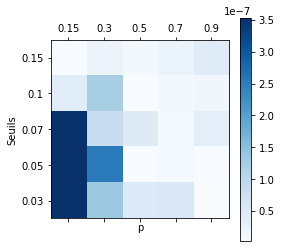

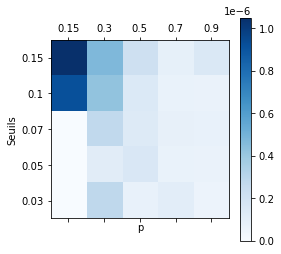

In [10]:
import matplotlib.pyplot as plt
seuils = [0.03, 0.05, 0.07, 0.1, 0.15]
seuils.reverse()
ps = [0.15, 0.3, 0.5, 0.7, 0.9]
# m = 1, n = 10
proba = np.load("probas.npy") - 3.53555e-7

plt.matshow(np.abs(proba.mean(axis=2)), cmap=plt.cm.Blues)
plt.xticks([0, 1, 2, 3, 4], ps)
plt.xlabel("p")
plt.yticks([0, 1, 2, 3, 4], seuils)
plt.ylabel("Seuils")
plt.colorbar()
plt.show()
plt.matshow(proba.std(axis=2), cmap=plt.cm.Blues)
plt.xticks([0, 1, 2, 3, 4], ps)
plt.xlabel("p")
plt.yticks([0, 1, 2, 3, 4], seuils)
plt.ylabel("Seuils")
plt.colorbar()
plt.show()

In [13]:
%%time
n=100
seuils = [0.05 + i / 100 for i in range(10)]
ps = [0.4 + i / 20 for i in range(10)]

proba = np.zeros((len(seuils), len(ps), n))

for i in range(len(seuils)):
  seuil = seuils[i]
  for j in range(len(ps)):
    p = ps[j]
    print("Processing with seuil = {}, p = {}".format(seuil, p))
    proba[i][j] = Splitting_Q1_1(a, seuil, M1, M2, n, lamb, T, p, P0, saut_1)
np.save("probas2", proba)

Processing with seuil = 0.05, p = 0.4



Processing with seuil = 0.05, p = 0.45



Processing with seuil = 0.05, p = 0.5



Processing with seuil = 0.05, p = 0.55



Processing with seuil = 0.05, p = 0.6000000000000001



Processing with seuil = 0.05, p = 0.65



Processing with seuil = 0.05, p = 0.7



Processing with seuil = 0.05, p = 0.75



Processing with seuil = 0.05, p = 0.8



Processing with seuil = 0.05, p = 0.8500000000000001



Processing with seuil = 0.060000000000000005, p = 0.4



Processing with seuil = 0.060000000000000005, p = 0.45



Processing with seuil = 0.060000000000000005, p = 0.5



Processing with seuil = 0.060000000000000005, p = 0.55



Processing with seuil = 0.060000000000000005, p = 0.6000000000000001



Processing with seuil = 0.060000000000000005, p = 0.65



Processing with seuil = 0.060000000000000005, p = 0.7



Processing with seuil = 0.060000000000000005, p = 0.75



Processing with seuil = 0.060000000000000005, p = 0.8



Processing with seuil = 0.060000000000000005, p = 0.8500000000000001



Processing with seuil = 0.07, p = 0.4



Processing with seuil = 0.07, p = 0.45



Processing with seuil = 0.07, p = 0.5



Processing with seuil = 0.07, p = 0.55



Processing with seuil = 0.07, p = 0.6000000000000001



Processing with seuil = 0.07, p = 0.65



Processing with seuil = 0.07, p = 0.7



Processing with seuil = 0.07, p = 0.75



Processing with seuil = 0.07, p = 0.8



Processing with seuil = 0.07, p = 0.8500000000000001



Processing with seuil = 0.08, p = 0.4



Processing with seuil = 0.08, p = 0.45



Processing with seuil = 0.08, p = 0.5



Processing with seuil = 0.08, p = 0.55



Processing with seuil = 0.08, p = 0.6000000000000001



Processing with seuil = 0.08, p = 0.65



Processing with seuil = 0.08, p = 0.7



Processing with seuil = 0.08, p = 0.75



Processing with seuil = 0.08, p = 0.8



Processing with seuil = 0.08, p = 0.8500000000000001



Processing with seuil = 0.09, p = 0.4



Processing with seuil = 0.09, p = 0.45



Processing with seuil = 0.09, p = 0.5



Processing with seuil = 0.09, p = 0.55



Processing with seuil = 0.09, p = 0.6000000000000001



Processing with seuil = 0.09, p = 0.65



Processing with seuil = 0.09, p = 0.7



Processing with seuil = 0.09, p = 0.75



Processing with seuil = 0.09, p = 0.8



Processing with seuil = 0.09, p = 0.8500000000000001



Processing with seuil = 0.1, p = 0.4



Processing with seuil = 0.1, p = 0.45



Processing with seuil = 0.1, p = 0.5



Processing with seuil = 0.1, p = 0.55



Processing with seuil = 0.1, p = 0.6000000000000001



Processing with seuil = 0.1, p = 0.65



Processing with seuil = 0.1, p = 0.7



Processing with seuil = 0.1, p = 0.75



Processing with seuil = 0.1, p = 0.8



Processing with seuil = 0.1, p = 0.8500000000000001



Processing with seuil = 0.11, p = 0.4



Processing with seuil = 0.11, p = 0.45



Processing with seuil = 0.11, p = 0.5



Processing with seuil = 0.11, p = 0.55



Processing with seuil = 0.11, p = 0.6000000000000001



Processing with seuil = 0.11, p = 0.65



Processing with seuil = 0.11, p = 0.7



Processing with seuil = 0.11, p = 0.75



Processing with seuil = 0.11, p = 0.8



Processing with seuil = 0.11, p = 0.8500000000000001



Processing with seuil = 0.12000000000000001, p = 0.4



Processing with seuil = 0.12000000000000001, p = 0.45



Processing with seuil = 0.12000000000000001, p = 0.5



Processing with seuil = 0.12000000000000001, p = 0.55



Processing with seuil = 0.12000000000000001, p = 0.6000000000000001



Processing with seuil = 0.12000000000000001, p = 0.65



Processing with seuil = 0.12000000000000001, p = 0.7



Processing with seuil = 0.12000000000000001, p = 0.75



Processing with seuil = 0.12000000000000001, p = 0.8



Processing with seuil = 0.12000000000000001, p = 0.8500000000000001



Processing with seuil = 0.13, p = 0.4



Processing with seuil = 0.13, p = 0.45



Processing with seuil = 0.13, p = 0.5



Processing with seuil = 0.13, p = 0.55



Processing with seuil = 0.13, p = 0.6000000000000001



Processing with seuil = 0.13, p = 0.65



Processing with seuil = 0.13, p = 0.7



Processing with seuil = 0.13, p = 0.75



Processing with seuil = 0.13, p = 0.8



Processing with seuil = 0.13, p = 0.8500000000000001



Processing with seuil = 0.14, p = 0.4



Processing with seuil = 0.14, p = 0.45



Processing with seuil = 0.14, p = 0.5



Processing with seuil = 0.14, p = 0.55



Processing with seuil = 0.14, p = 0.6000000000000001



Processing with seuil = 0.14, p = 0.65



Processing with seuil = 0.14, p = 0.7



Processing with seuil = 0.14, p = 0.75



Processing with seuil = 0.14, p = 0.8



Processing with seuil = 0.14, p = 0.8500000000000001



CPU times: user 7h 12min 28s, sys: 3.27 s, total: 7h 12min 31s
Wall time: 7h 12min 48s


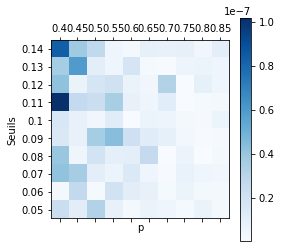

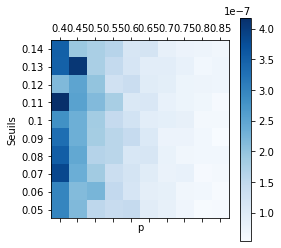

In [18]:
seuils = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]
seuils.reverse()
ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

proba = np.load("probas2.npy")

plt.matshow(np.abs(proba.mean(axis=2)), cmap=plt.cm.Blues)
plt.xticks([i for i in range(10)], ps)
plt.xlabel("p")
plt.yticks([i for i in range(10)], seuils)
plt.ylabel("Seuils")
plt.colorbar()
plt.show()
plt.matshow(proba.std(axis=2), cmap=plt.cm.Blues)
plt.xticks([i for i in range(10)], ps)
plt.xlabel("p")
plt.yticks([i for i in range(10)], seuils)
plt.ylabel("Seuils")
plt.colorbar()
plt.show()

In [48]:
def xtick():
    lis = []
    for i in range(10):
        for j in range(10):
            if i == 0 and j == 0:
                lis.append("Seuil \n p")
            elif j == 4:
                lis.append(str(seuils[i]) + "\n" + str(ps[j]))
            else:
                lis.append(" \n" + str(ps[j]))
    return lis

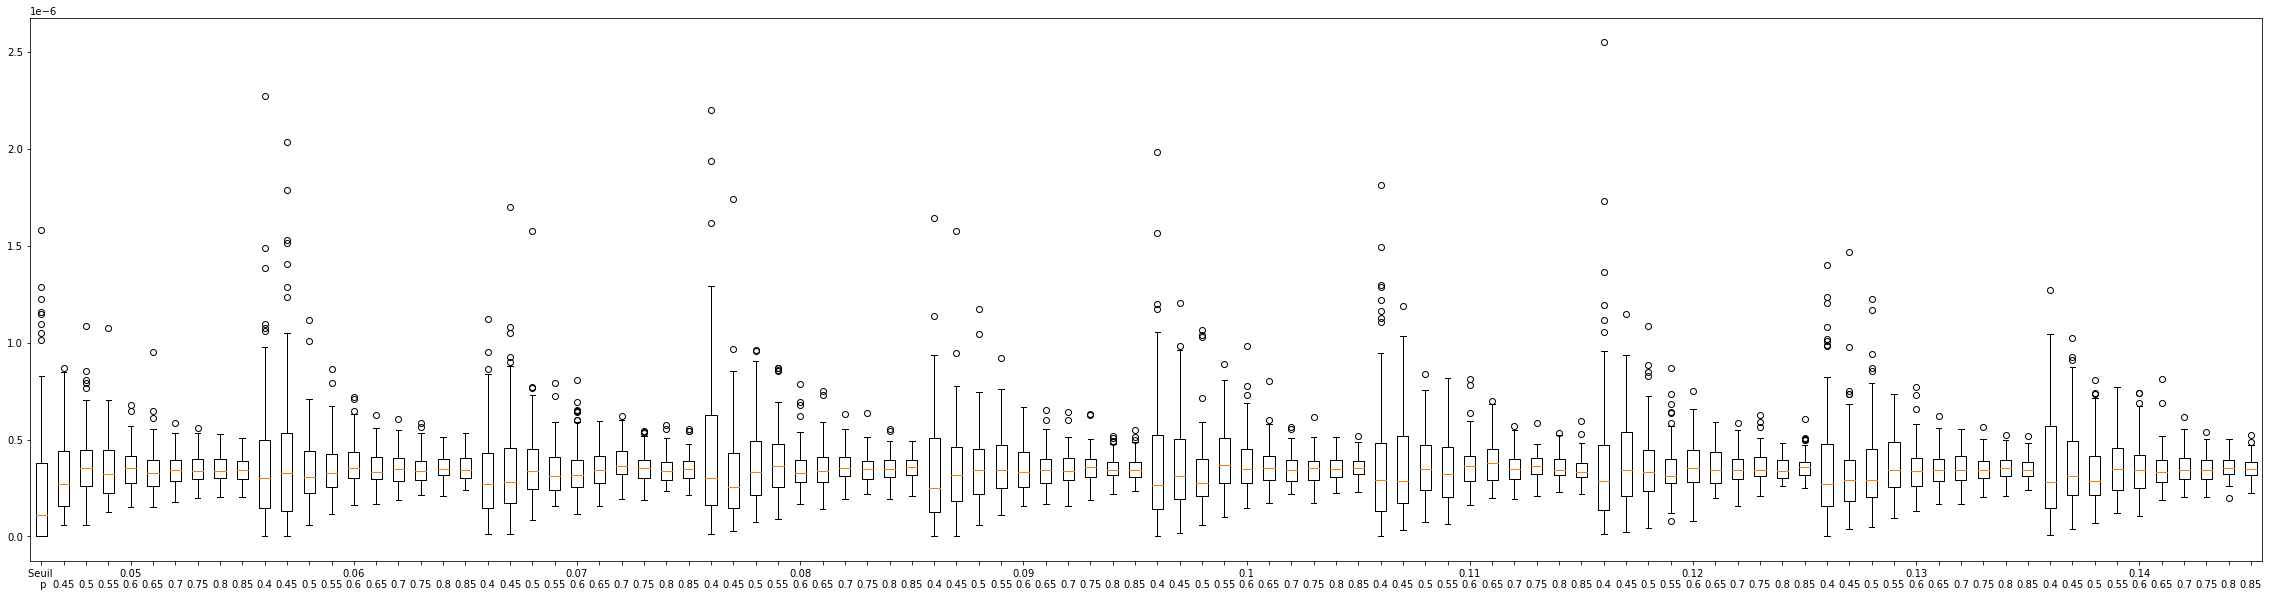

In [49]:
seuils = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]
ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

plt.figure(figsize=(40, 10))
proba = np.load("probas2.npy")
plt.boxplot([proba[i][j] for i in range(10) for j in range(10)])
plt.xticks([i+1 for i in range(100)], xtick())
plt.savefig("result.png")

{'whiskers': [<matplotlib.lines.Line2D at 0x7efbde6836a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efbde683da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efbde683390>,
 'medians': [<matplotlib.lines.Line2D at 0x7efbde60f4e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efbde60f860>,
 'means': []}

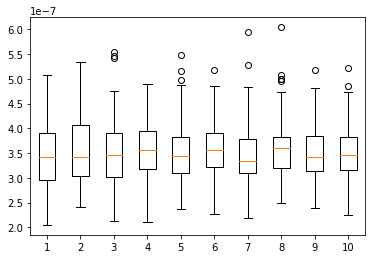

In [8]:
import matplotlib.pyplot as plt
seuils = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]
ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

proba = np.load("probas2.npy")
plt.boxplot([proba[i, 9] for i in range(10)])
#plt.xticks([i+1 for i in range(100)], xtick())
#plt.savefig("result.png")

In [ ]:
print("Estimation de la probabilité de ruine pour m=1 par méthode de Splitting/MCMC: {:09.8f}+/-{:09.8f}".format(proba_emp,sigma_emp))